In [342]:
import numpy as np
from keras.preprocessing import sequence
from keras.models import Sequential
from keras.layers import Dense, Embedding
from keras.layers import LSTM
from keras.datasets import imdb
import keras.backend as K

from keras.callbacks import ModelCheckpoint
from keras.models import Model, load_model, Sequential
from keras.layers import Dense, Activation, Dropout, Input, Masking, TimeDistributed, LSTM, Conv1D
from keras.layers import GRU, Bidirectional, BatchNormalization, Reshape
from keras.optimizers import Adam, SGD
from keras.utils import to_categorical

from scipy.stats import norm

In [343]:
train = np.load("resources/data/discords/dutch_power/train.npy")
validation = np.load("resources/data/discords/dutch_power/validation.npy")
test = np.load("resources/data/discords/dutch_power/test.npy")

# preprocessing
mean_x = np.mean(train[:,0])
std_x = np.std(train[:,0])

test_labels = test[:,1]

train = (train[:,0] - mean_x)/std_x
validation = (validation[:,0] - mean_x)/std_x
test = (test[:,0] - mean_x)/std_x

In [344]:
def prepare_seq2seq_data(dataset, look_back, look_ahead):
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - look_ahead +1):
        input_seq = dataset[i:(i + look_back)]
        output_seq = dataset[i + look_back:(i + look_back + look_ahead)]
        dataX.append(input_seq)
        dataY.append(output_seq)
    dataX = np.reshape(np.array(dataX),[-1,look_back,1])
    dataY = np.reshape(np.array(dataY),[-1,look_ahead,1])
    return dataX, dataY

look_back = 24
look_ahead = 1

X_train, y_train = prepare_seq2seq_data(train,look_back,look_ahead)
X_validation, y_validation =  prepare_seq2seq_data(validation,look_back,look_ahead)
X_test, y_test = prepare_seq2seq_data(test,look_back,look_ahead)
X_test_labels,y_test_labels = prepare_seq2seq_data(test_labels,look_back,look_ahead)

# 1 step look ahead
y_train = y_train.reshape(len(y_train),1)
y_validation = y_validation.reshape(len(y_validation),1)
y_test = y_test.reshape(len(y_test),1)

In [345]:
def model(input_shape, droprate = 0.2):
    X_input = Input(batch_shape = input_shape)
    X = LSTM(units = 300, dropout = droprate, recurrent_dropout = droprate, stateful = True, return_sequences=False)(X_input)
    #X = LSTM(units = 20, dropout = droprate, recurrent_dropout = droprate, return_sequences=False)(X)
    X = Dropout(droprate)(X)
    X = Dense(1, activation='linear')(X)
    
    model = Model(inputs = X_input, outputs = X)
    return model

lstm = model((672, look_back,look_ahead))
lstm.summary()
lstm.compile(loss='mse',
             optimizer='adam',
             metrics=['mse'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_23 (InputLayer)        (672, 24, 1)              0         
_________________________________________________________________
lstm_23 (LSTM)               (672, 300)                362400    
_________________________________________________________________
dropout_20 (Dropout)         (672, 300)                0         
_________________________________________________________________
dense_20 (Dense)             (672, 1)                  301       
Total params: 362,701
Trainable params: 362,701
Non-trainable params: 0
_________________________________________________________________


In [346]:
lstm.compile(loss='mse',
             optimizer='adam',
             metrics=['mse'])

filepath="lstm.h5"
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
callbacks_list = [checkpoint]
num_epochs = 50


lstm.fit(X_train, y_train,
         epochs= 50,
         batch_size= 672, shuffle = False, validation_data= (X_validation, y_validation),callbacks=callbacks_list)

hidden_states = K.eval(lstm.layers[1].states[0])
cell_states = K.eval(lstm.layers[1].states[1])

Train on 6048 samples, validate on 1344 samples
Epoch 1/50
6048/6048 [==============================] - 14s - loss: 0.5528 - mean_squared_error: 0.5528 - val_loss: 0.1899 - val_mean_squared_error: 0.1899
Epoch 2/50
6048/6048 [==============================] - 12s - loss: 0.2910 - mean_squared_error: 0.2910 - val_loss: 0.0970 - val_mean_squared_error: 0.0970
Epoch 3/50
6048/6048 [==============================] - 13s - loss: 0.2542 - mean_squared_error: 0.2542 - val_loss: 0.1154 - val_mean_squared_error: 0.1154
Epoch 4/50
6048/6048 [==============================] - 12s - loss: 0.2513 - mean_squared_error: 0.2513 - val_loss: 0.0763 - val_mean_squared_error: 0.0763
Epoch 5/50
6048/6048 [==============================] - 13s - loss: 0.2333 - mean_squared_error: 0.2333 - val_loss: 0.0828 - val_mean_squared_error: 0.0828
Epoch 6/50
6048/6048 [==============================] - 13s - loss: 0.2323 - mean_squared_error: 0.2323 - val_loss: 0.0820 - val_mean_squared_error: 0.0820
Epoch 7/50
6048/

6048/6048 [==============================] - 12s - loss: 0.0568 - mean_squared_error: 0.0568 - val_loss: 0.0502 - val_mean_squared_error: 0.0502
Epoch 28/50
6048/6048 [==============================] - 12s - loss: 0.0532 - mean_squared_error: 0.0532 - val_loss: 0.0469 - val_mean_squared_error: 0.0469
Epoch 29/50
6048/6048 [==============================] - 12s - loss: 0.0546 - mean_squared_error: 0.0546 - val_loss: 0.0516 - val_mean_squared_error: 0.0516
Epoch 30/50
6048/6048 [==============================] - 12s - loss: 0.0571 - mean_squared_error: 0.0571 - val_loss: 0.0482 - val_mean_squared_error: 0.0482
Epoch 31/50
6048/6048 [==============================] - 12s - loss: 0.0514 - mean_squared_error: 0.0514 - val_loss: 0.0438 - val_mean_squared_error: 0.0438
Epoch 32/50
6048/6048 [==============================] - 12s - loss: 0.0486 - mean_squared_error: 0.0486 - val_loss: 0.0488 - val_mean_squared_error: 0.0488
Epoch 33/50
6048/6048 [==============================] - 12s - loss: 0

In [347]:
lstm.load_weights('lstm.h5')

K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
print 'mse of training: ', lstm.evaluate(X_train, y_train,batch_size= 672)[0]

K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
print 'mse of validation: ', lstm.evaluate(X_validation, y_validation, batch_size= 672)[0]

K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
print 'mse of test: ', lstm.evaluate(X_test, y_test,batch_size= 672)[0]

6048/6048 [==============================] - 4s     
 0.04510047659277916
1344/1344 [==============================] - 0s     
 0.040373312309384346
6048/6048 [==============================] - 4s     
 0.0637014653119776


In [348]:
# MC dropout
def predict_with_uncertainty(f, x, n_iter=500):
    result = [0 for i in range(n_iter)]
    for iter in range(n_iter):
        if iter%100 == 0:
            print 'iteration: ', iter  
            
        K.set_value(lstm.layers[1].states[0],hidden_states)
        K.set_value(lstm.layers[1].states[1],cell_states)
        
        f = K.function([lstm.layers[0].input, K.learning_phase()],
               [lstm.layers[-1].output])
        result[iter] = []
        for i in range(0, len(x), 672):
            result[iter].append(f((x[i:i+672],1))[0])
        result[iter] = np.concatenate(result[iter])
        
    return result

K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
pred_validation = predict_with_uncertainty(f, X_validation, n_iter=500)

K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
pred_test = predict_with_uncertainty(f, X_test, n_iter=500)

iteration:  0
iteration:  100
iteration:  200
iteration:  300
iteration:  400
iteration:  0
iteration:  100
iteration:  200
iteration:  300
iteration:  400


In [349]:
pred_validation = np.array(pred_validation).reshape(len(pred_validation), len(pred_validation[0]))
pred_test = np.array(pred_test).reshape(len(pred_test), len(pred_test[0]))

pred_validation = pred_validation*std_x  + mean_x
pred_test = pred_test*std_x + mean_x

np.save('resources/data/discords/dutch_power/pred_validation.npy',pred_validation)
np.save('resources/data/discords/dutch_power/pred_test.npy',pred_test)

In [350]:
#lstm.reset_states()
K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
pred_train_point = lstm.predict(X_train, batch_size = 672)
pred_train_point = pred_train_point*std_x + mean_x

K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
pred_test_point = lstm.predict(X_test, batch_size = 672)
pred_test_point = pred_test_point*std_x + mean_x

#lstm.reset_states()
K.set_value(lstm.layers[1].states[0],hidden_states)
K.set_value(lstm.layers[1].states[1],cell_states)
pred_validation_point = lstm.predict(X_validation,batch_size = 672)
pred_validation_point = pred_validation_point*std_x + mean_x

np.save('resources/data/discords/dutch_power/pred_train_point.npy',pred_train_point)
np.save('resources/data/discords/dutch_power/pred_test_point.npy',pred_test_point)
np.save('resources/data/discords/dutch_power/pred_validation_point.npy',pred_validation_point)


y_test = y_test*std_x + mean_x
y_train = y_train*std_x + mean_x
y_validation = y_validation*std_x + mean_x

## prediction

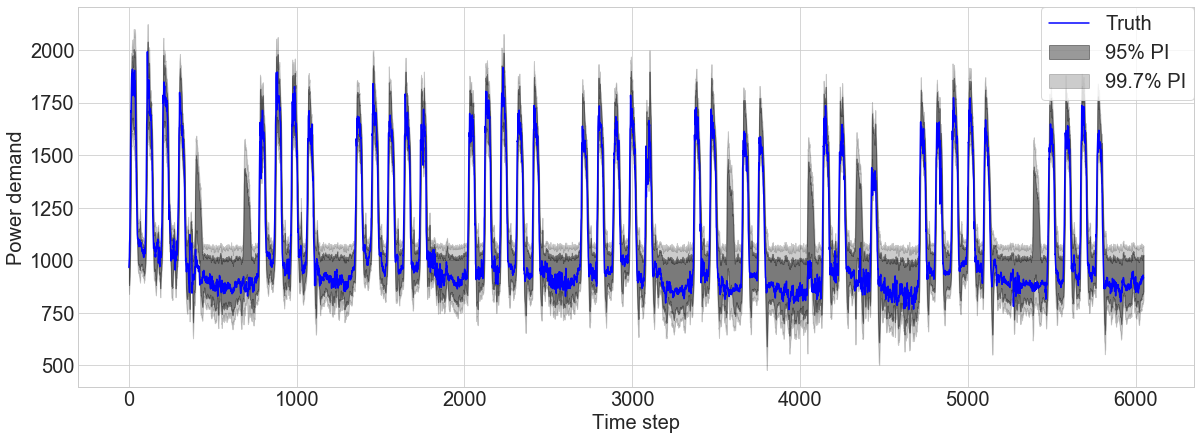

In [351]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
%matplotlib inline

def prediction_plot(pred_res, truth, true_anormalies, name = ''):
    pred_mean = np.mean(pred_res, axis = 0)
    pred_std = np.std(pred_res, axis = 0)

    plt.figure(figsize = (20, 7))
    lower1 = pred_mean - 2*pred_std
    upper1 = pred_mean + 2*pred_std 
    
    lower2 = pred_mean - 3*pred_std
    upper2 = pred_mean + 3*pred_std
    
    plt.fill_between(range(len(truth)), lower1, upper1, color ='k', alpha =0.4, label ='95% PI')
    plt.fill_between(range(len(truth)), lower2, upper2, color ='k', alpha =0.2, label ='99.7% PI')
    
    plt.plot(truth, 'b', label='Truth')
    
    for i in range(len(true_anormalies)):
        if i == 0:
            plt.plot(true_anormalies[i], truth[true_anormalies[i]], 'ro', markersize = 5, alpha =0.4, label ='Anormaly')
        plt.plot(true_anormalies[i], truth[true_anormalies[i]], 'ro', markersize = 5, alpha =0.4)

    plt.xlabel('Time step',fontsize=20)
    plt.ylabel('Power demand',fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    plt.legend(bbox_to_anchor=(1, 1),loc="upper right", borderaxespad=0.,frameon=True,prop={'size': 20})
    plt.savefig(name,format='pdf', dpi=300)

y_test_labels = y_test_labels.reshape(len(y_test_labels), )
true_anormalies = np.where(y_test_labels==1)[0]
prediction_plot(pred_test,y_test, true_anormalies, name = 'power_demand_test_dataset_005.pdf')

## prediction error distribution

In [352]:
error_validation = y_validation - pred_validation_point
me_validation = np.mean(error_validation)
stde_validation = np.std(error_validation)

In [353]:
error_train = y_train - pred_train_point
me_train = np.mean(error_train)
stde_train = np.std(error_train)

In [354]:
endpoints = norm.interval(0.997, loc = me_validation, scale = stde_validation)
error_test = (y_test - pred_test_point).reshape(len(y_test), )

true_anormalies_test = np.where(y_test_labels==1)[0]
outliers_test = np.where((error_test <endpoints[0]) | (error_test >endpoints[1]))[0]

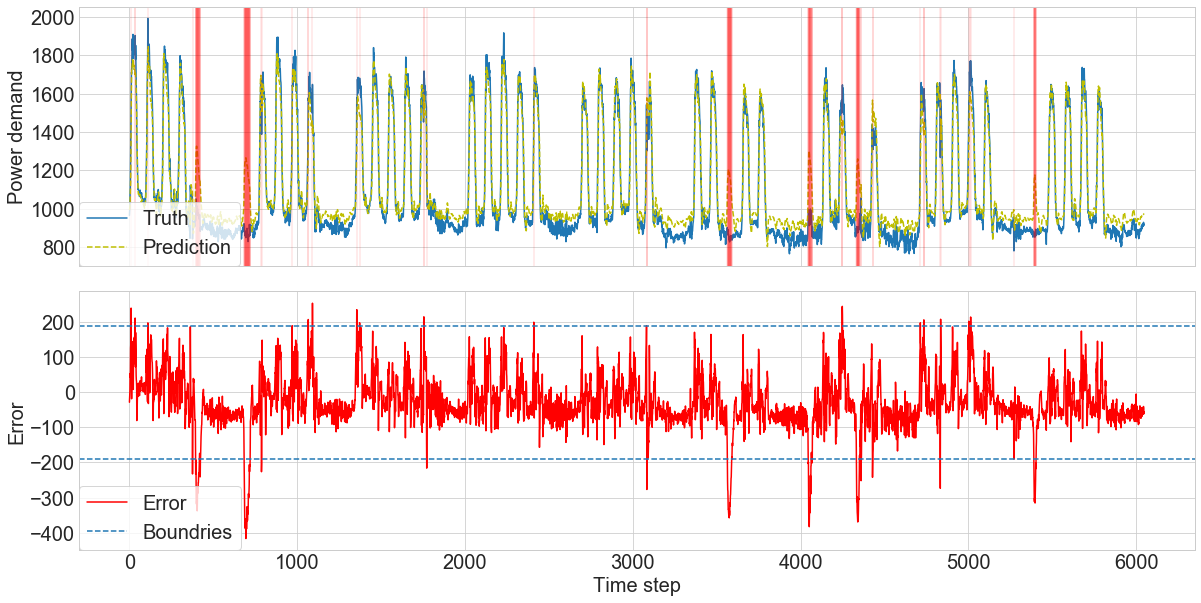

In [355]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)
ax1 = plt.subplot(211)
ax1.plot(y_test, label='Truth')
ax1.plot(pred_test_point,ls ='dashed',label='Prediction',color ='y')
#ax1.plot((y_test - pred_test_point),label='Error', color ='r')

for loc in outliers_test:
    ax1.axvline(x=loc,color='r',alpha=.1)

for anormaly in true_anormalies_test:
    ax1.plot(anormaly, y_test[anormaly], 'k.', markersize=20.0, alpha=0.4)

plt.ylabel('Power demand',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(0, 0),loc="lower left", borderaxespad=0.,frameon=True,prop={'size': 20})


ax2 = plt.subplot(212, sharex=ax1)
ax2.plot(y_test - pred_test_point,label='Error', color ='r')
ax2.axhline(y=endpoints[0],ls='dashed',label='Boundries')
ax2.axhline(y=endpoints[1],ls='dashed')
plt.legend(bbox_to_anchor=(0, 0),loc="lower left", borderaxespad=0.,frameon=True,prop={'size': 20})

xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)
plt.xlabel("Time step",fontsize=20)
plt.ylabel("Error",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)


plt.savefig('power_demand_error_dist_result_005.pdf',format='pdf', dpi=300)

## MC dropout

In [391]:
mean_pred_validation = np.mean(pred_validation,axis=0)
std_pred_validation = np.std(pred_validation, axis=0)
std_max = std_pred_validation.max()

from scipy.stats import norm
p_value_validation = []

for i in range(len(y_validation)):
    cdf = norm.cdf(y_validation[i], loc = mean_pred_validation[i], scale = std_pred_validation[i])
    p_value_validation.append(min(cdf, 1-cdf))

p_value_validation= np.array(p_value_validation).reshape(len(p_value_validation),)
p_value_max = p_value_validation.max()
p_value_II = std_pred_validation/std_max- np.array(p_value_validation)/p_value_max

_,threshold = norm.interval(0.997, loc = p_value_II.mean(), scale = p_value_II.std())

In [392]:
p_value_std_validation = std_pred_validation/std_max
p_value_std = std_pred_test/std_max
_,threshold_std = norm.interval(0.997, loc = p_value_std_validation.mean(), scale = p_value_std_validation.std())

In [393]:
mean_pred_test = np.mean(pred_test,axis=0)
std_pred_test = np.std(pred_test, axis=0)

outliers_test = []

pred_test = np.sort(pred_test,axis=0)

p_value_test = []

for i in range(len(y_test)):
    cdf = norm.cdf(y_test[i], loc = mean_pred_test[i], scale = std_pred_test[i])
    p_value_test.append(min(cdf, 1-cdf))

p_value_test= np.array(p_value_test).reshape(len(p_value_test),)
p_value_II = std_pred_test/std_max - np.array(p_value_test)/p_value_max

for i in range(len(y_test)): 
    if p_value_II[i] > threshold:
        outliers_test.append(i)
    #if p_value_std[i] > threshold_std:
    #    outliers_test.append(i)    
true_anormalies_test = np.where(y_test_labels==1)[0]

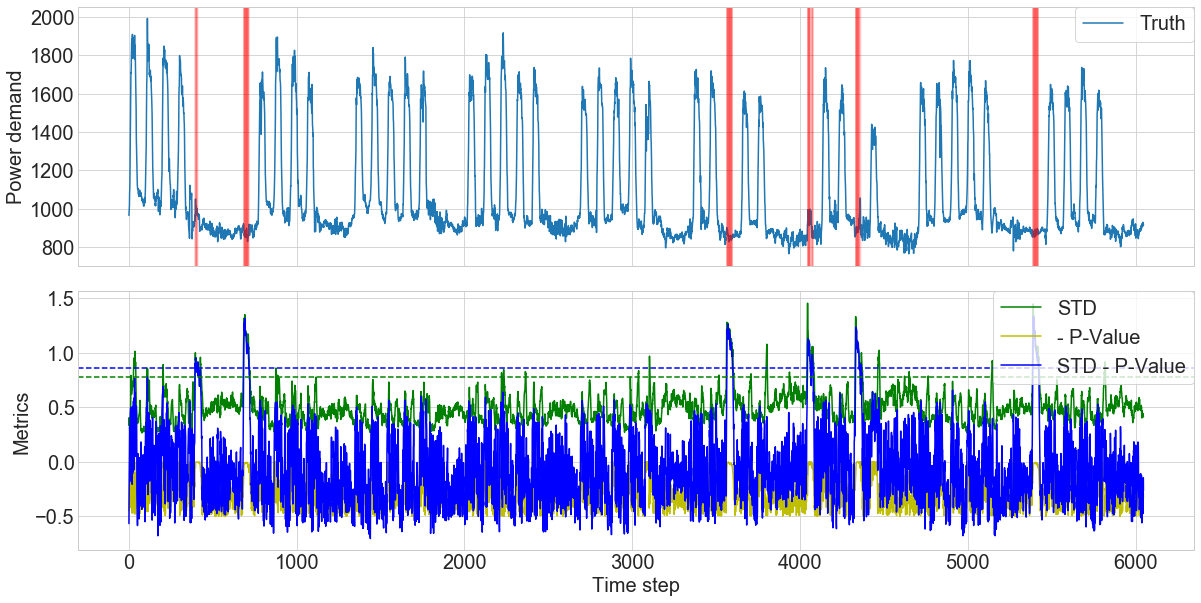

In [394]:
plt.figure(figsize=(20,10))
plt.subplots_adjust(hspace=0.1)
ax1 = plt.subplot(211)
ax1.plot(y_test, label='Truth')
for loc in outliers_test:
    ax1.axvline(x=loc,color='r',alpha=0.1)

for anormaly in true_anormalies_test:
    ax1.plot(anormaly, y_test[anormaly], 'k.', markersize=30.0, alpha=0.4)

plt.ylabel('Power demand',fontsize=20)
plt.yticks(fontsize=20)
plt.legend(bbox_to_anchor=(1, 1),loc="upper right", borderaxespad=0.,frameon=True,prop={'size': 20})

ax2 = plt.subplot(212)
ax2.plot(std_pred_test/std_max, label = 'STD', color = 'g')
ax2.plot(-p_value_test, label = '- P-Value', color = 'y')
ax2.plot(p_value_II, label = 'STD - P-Value', color = 'b')

ax2.axhline(y=threshold,ls='dashed', color = 'b')
ax2.axhline(y=threshold_std,ls='dashed', color = 'g')

plt.legend(bbox_to_anchor=(1, 1),loc="upper right", borderaxespad=0.,frameon=True,prop={'size': 20})

xticklabels = ax1.get_xticklabels()
plt.setp(xticklabels, visible=False)

plt.xlabel("Time step",fontsize=20)
plt.ylabel("Metrics",fontsize=20)
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

plt.savefig('power_demand_MC_dropout_results_005.pdf',format='pdf', dpi=300)